# LOGISTIC REGRESSION CASE STUDY

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Description

In [152]:
# MemberID numbers the patients from 1 to 131, and is just an identifying number.
# InpatientDays is the number of inpatient visits, or number of days the person spent in the hospital.
# ERVisits is the number of times the patient visited the emergency room.
# OfficeVisits is the number of times the patient visited any doctor’s office.
# Narcotics is the number of prescriptions the patient had for narcotics.
# DaysSinceLastERVisit is the number of days between the patient’s last emergency room visit 
# Pain is the number of visits for which the patient complained about pain.
# TotalVisits is the total number of times the patient visited any healthcare provider.
# ProviderCount is the number of providers that served the patient.
# MedicalClaims is the number of days on which the patient had a medical claim.
# ClaimLines is the total number of medical claims.
# StartedOnCombination is whether or not the patient was started on a combination of drugs to treat their diabetes (TRUE or FALSE).
# AcuteDrugGapSmall is the fraction of acute drugs that were refilled quickly after the prescription ran out.
# PoorCare is the outcome or dependent variable, and is equal to 1 if the patient had poor care, and equal to 0 if the patient had good care.

In [153]:
df=pd.read_csv("quality.csv")#read the csv into python

In [154]:
df.head()

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall,PoorCare
0,1,0,0,18,1,731.0,10,18,21,93,222,False,0,0
1,2,1,1,6,1,411.0,0,8,27,19,115,False,1,0
2,3,0,0,5,3,731.0,10,5,16,27,148,False,5,0
3,4,0,1,19,0,158.0,34,20,14,59,242,False,0,0
4,5,8,2,19,3,449.0,10,29,24,51,204,False,0,0


In [155]:
df.columns#lets look at the columns

Index([u'MemberID', u'InpatientDays', u'ERVisits', u'OfficeVisits',
       u'Narcotics', u'DaysSinceLastERVisit', u'Pain', u'TotalVisits',
       u'ProviderCount', u'MedicalClaims', u'ClaimLines',
       u'StartedOnCombination', u'AcuteDrugGapSmall', u'PoorCare'],
      dtype='object')

In [156]:
#proportion of 1;s and 0's
df['PoorCare'].value_counts()
#So a baseline model will always predict 0 and its accuracy will be
# 98/(98+33)=  74.8%
#so out logistic regression should score more than this ..

0    98
1    33
Name: PoorCare, dtype: int64

# Exploratory Data Analysis

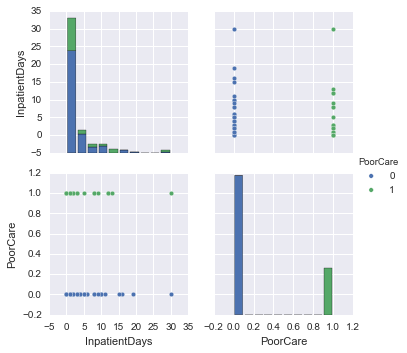

In [157]:
#BIVARIATE ANALYSIS
#lets Analyse the Column InpatientDays wrt the DV Poor Care
#Inpatient Days is a Continuous Independent variable
#so lets draw a histogram and color it on basis of the DV
import seaborn as sns
%matplotlib inline
sns.pairplot(df[["InpatientDays","PoorCare"]],hue="PoorCare")
#if we see the first plot carefully, both colors 0 and 1 appear in all of the bars..
#if we had any bar of one single color, we could make use of it to predict PoorCare
#hence this variable doesnt look to be significant

In [158]:
#I did the same as above with ERVisits, OfficeVisits,
#ProviderCount, MedicalClaims, ClaimLines,AcuteDrugGapSmall. The plots for these too did not seem
#very interesting.

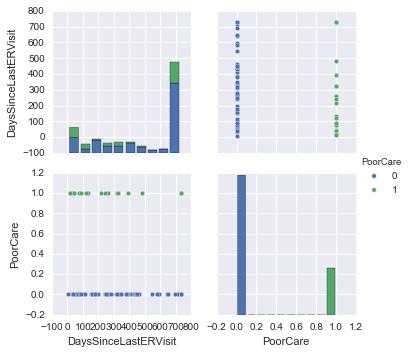

In [159]:
#lets try DaysSinceLastERVisit
sns.pairplot(df[["DaysSinceLastERVisit","PoorCare"]],hue="PoorCare")
#This plot looks interesting as the 3rd, 6th to 9th bar are purely 0;s. This is what we were loking for .
#it seems this variable maybe inportant. Lets keep it for including in our model
#Similarly I found --> Narcotics, Pain, TotalVisit to be somewhat significant.
#this might be difficult sometime, hence we will also have a look at the P vlaues to confirm that
#these variables are significant

In [160]:
#but since these variables DaysSinceLastERVisit, Narcotics, Pain, TotalVisit are 
#continuous We might have to check for multicollinearity.
#only if these are not corelated we can use them in Modeling
#lets select these columns by their indexes
df.iloc[:,[4,5,6,7]].corr()
#No significant co-relation observed.

,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits
Narcotics,1.000000,0.065055,0.106860,0.163992
DaysSinceLastERVisit,0.065055,1.000000,-0.358781,-0.344640
Pain,0.106860,-0.358781,1.000000,0.482959
TotalVisits,0.163992,-0.344640,0.482959,1.000000


In [161]:
#StartedOnCombination is a categorical variable taking only True and False
#this is a case of both DV and IV being Categorical. We can study this by a pLot or by a cross tab
pd.crosstab(df['PoorCare'],df['StartedOnCombination'])
# this means that if StartedOnCombination is True for any patient, he must have received POOR
#Care sicne 5 f them received Poor Care and Only 1 received Good Care.
#so this variable is also Significant.
#lets use this variable as well in our Model
# but we will have to convert it to dummy variable as this is categorical
# TO read more about this..watch the LINEAR REGRESSION CASE STUDY VIDEO.
#IT has details on DUMMY VARIABLES concept and codes
temp=pd.get_dummies(df['StartedOnCombination'],drop_first=True)
#merge this with original dataset
df_final=pd.concat([df,temp],axis=1)
#We no longer need the original StartedOnCombination as we have created dummies for it,
#so lets delete this StartedOnCombination from the df_final
df_final=df_final.drop(['StartedOnCombination'],axis=1)
print df_final.columns # this tells us that the dummy variable created for StartOnCombination 
# is named True. We will add this to our model

Index([            u'MemberID',        u'InpatientDays',
                   u'ERVisits',         u'OfficeVisits',
                  u'Narcotics', u'DaysSinceLastERVisit',
                       u'Pain',          u'TotalVisits',
              u'ProviderCount',        u'MedicalClaims',
                 u'ClaimLines',    u'AcuteDrugGapSmall',
                   u'PoorCare',                    True],
      dtype='object')


# Model Building

In [162]:
#lets start buliding the model
from sklearn.linear_model import LogisticRegression

In [163]:
log_reg=LogisticRegression(C = 1e9)  # C=1e9 is added for some complex reason.. Memorize this.

In [164]:
#similar to what we do n Linear regression we split the data into 2 parts..
# And define the DV and IVs.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final[["DaysSinceLastERVisit","Narcotics","Pain","TotalVisits",True]],df_final['PoorCare'],test_size=0.3,random_state=1)

In [165]:
#predict on train data
log_reg.fit(X_train,y_train)
pred_train=log_reg.predict(X_train)
pd.crosstab(y_train,pred_train)
#accuracy=(70+9)/(70+9+11+1)
#accuracy=86% on training data

col_0,0,1
PoorCare,,
0,70,1
1,11,9


In [166]:
pred=log_reg.predict(X_test)#to get the output as 1's and 0's
#by assuming t=0.5

In [167]:
#confusion matrix
pd.crosstab(y_test,pred)

col_0,0,1
PoorCare,,
0,23,4
1,6,7


In [168]:
TP=7.0
TN=23.0
FP=4.0
FN=6.0
#error on the test data
accuracy= float((TP+TN)/len(y_test))
error=float((FP+FN)/len(y_test))
print ("Accuracy is ")+ str(accuracy)
print ("error is ")+ str(error)
#print the coefficients
print "the coefficients are "+ str(log_reg.coef_)
print "the intercept is "+ str(log_reg.intercept_)
#we have got 75% accuracy, better than the baseline model
#similarly you can also calulate Sensitivity, Specificity and Precision

Accuracy is 0.75
error is 0.25
the coefficients are [[ -2.34777294e-03   1.32117981e-01  -3.96613720e-02   5.94438370e-02
    2.74713754e+00]]
the intercept is [-1.52482037]


In [169]:
#Also comparing the accuracy of Train 86% and test 75% , it looks like we have silghtly overfit..
# we can try to exclude some variables to get a better fit and reduce complexity of the model

In [170]:
#so fro above we get the equation of the Logistic regression
#
#P(y=1)= 1/ 1+e^(-1.52 -0.0023*DaysSinceLastERVisit+0.132*Narcotics-... and so on.)
#INTERPRETATION OF THE MODEL-----------------------------------------------------
#This means that icreasing DaysSinceLastERVisit,Pain (negative coefficient) takes you towards P(y=0) or PoorCare(0). 
#This maskes sense as well
#Similarly higher value of Narcotics & TotalVisits would means you are more likely to have 
#reveived Poor Care. This too makes sense( read the variable description at the begining)

In [171]:
pred1=log_reg.predict_proba(X_test)# to get probabilities instead of classes

# ROC CURVE

(-0.05, 1.05)

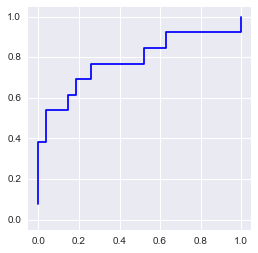

In [172]:
#lets us look at ROC curve
#dont worry about the codes fro ROC curve.. You dont have to remember it.. Just know its application
#to read more about ROC curve refer---->
# http://blog.yhat.com/posts/roc-curves.html or http://www.dataschool.io/roc-curves-and-auc-explained/
fpr, tpr, threshold= metrics.roc_curve(y_test, pred1[:,1]) #pass the actual test DV and 
#predicted probability (only P(y)=1)
#**********DRAW ROC CURVE**************
plt.plot(fpr, tpr, label='ROC curve', color='b')
plt.axes().set_aspect('equal')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

In [173]:
AUC= metrics.auc(fpr,tpr) # to get the area under the Curve
print AUC #78% which is good. this means model is covering 78% of the datapoints well. Best value is 1
#worst is 0

0.783475783476


In [174]:
from sklearn import metrics

In [175]:
#CONVERT THE PROBABILITITS TO 1'S AND 0'S APPLYING OUT OWN THRESHOLD
#HERE 0.40
x=[]
for i in range(len(pred1[:,1])):
    if (pred1[:,1][i]>=0.4):
        x.append(1)
    else:
        x.append(0)
x=np.array(x)
pd.crosstab(y_test,x)

col_0,0,1
PoorCare,,
0,23,4
1,5,8


In [176]:
#output 2
TP=8.0
TN=23.0
FP=4.0
FN=5.0
#error on the test data
accuracy= float((TP+TN)/len(y_test))
error=float((FP+FN)/len(y_test))
print accuracy
print error
#slightly better than before
#similarly you can also calulate Sensitivity, Specificity and Precision

0.775
0.225


In [177]:
#lets see the P values to verify if we have used all Good variables

In [178]:
import statsmodels.discrete.discrete_model as sm
from statsmodels.api import add_constant
X2 = add_constant(X_train)

In [179]:
logit = sm.Logit(y_train, X2)

In [180]:
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.370628
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               PoorCare   No. Observations:                   91
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Dec 2017   Pseudo R-squ.:                  0.2962
Time:                        00:36:26   Log-Likelihood:                -33.727
converged:                       True   LL-Null:                       -47.923
                                        LLR p-value:                 3.050e-05
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                   -1.5322      0.805     -1.904      0.057        -3.109     0.045

In [181]:
# we see from abve that Pain and Total Visits are not imprtant pain 14% and Total Visits 9.6%
#let lets exclude them and recheck the model

In [182]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final[["DaysSinceLastERVisit","Narcotics",True]],df_final['PoorCare'],test_size=0.3,random_state=1)

In [183]:
log_reg=LogisticRegression(C = 1e9)
log_reg.fit(X_train,y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [184]:
#predict on train data
pred_train=log_reg.predict(X_train)
pd.crosstab(y_train,pred_train)
#accuracy=(70+9)/(70+9+11+1)
#accuracy=86% on training data
#similarly you can also calulate Sensitivity, Specificity and Precision

col_0,0,1
PoorCare,,
0,70,1
1,11,9


In [185]:
#predict on test
pred=log_reg.predict(X_test)#to get the output as 1's and 0's
#by assuming t=0.5
#confusion matrix
pd.crosstab(y_test,pred)
#test data accuracy= 27+5=32
print "accuracy is "+ str(32.0/40) #80% better than previous result and very close to train data accuracy (86%).
#this is random variation.
#hence overfitting has been removed. 

accuracy is 0.8


In [186]:
#so final model will have only DaysSinceLastERVisit","Narcotics" & 
#StartedOnCombination(dummy of this) as the INDEPENDENT VARIABLES

In [94]:
#HOPE THIS CASE STUDY HELPED YOU. THIS IS HOW TO PROCEED WITH ANY DATA.. ONE STEP AT A TIME.
# NURTURING YOUR DATA SCIECNE JOURNEY AND HONING YOUR SKILLS.
# MAIL AT BANGALOREDATASCIENCEACADEMY@GMAIL.COM FOR MORE SUCH CASE STUDIES